# Evaluation of Semantic Search


## Data preparation


In [1]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import CrossEncoder
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import Dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import faiss
import torch
import os

load_dotenv()

True

In [2]:
topic_data_df = pd.read_csv('../tattoos/topic_data.csv')[['post_id', 'Title', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Topic', 'Topic_Description']]
topic_data_df.head()

,post_id,Title,tattoo_description,tattoo_color,tattoo_style,Topic,Topic_Description
0,16fjoi5,Good placement for a goofy tattoo when you hav...,a cute kitten standing behind a wine glass,black,illustrative,0,"Cats (cats, kittens, furry pets)"
1,t0s1uk,"Recently got this cat, and the “x” looks like ...",black cat tattoo with a cross on its back,black,illustrative,0,"Cats (cats, kittens, furry pets)"
2,14wkvrl,"My friend who is a tattoo artist, designed my ...",a traditional style tattoo featuring a cat wit...,multicolored,traditional,0,"Cats (cats, kittens, furry pets)"
3,txcbmr,"Pretty cute cat astronaut @ Freedom Ink, Brazil",black and white tattoo of a cat in an astronau...,black,illustrative,0,"Cats (cats, kittens, furry pets)"
4,1eg49eq,Just wanted to share my new car tattoo cuz I’m...,a detailed black and grey tattoo of a demonic ...,black gray,realism,0,"Cats (cats, kittens, furry pets)"


In [3]:
topic_data_df.dropna(subset=['post_id', 'Title', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Topic_Description', 'Topic'], inplace=True)

topic_data_df['text'] = (
    topic_data_df['Title'] + " \n " +
    topic_data_df['tattoo_description'] + " \n " +
    topic_data_df['tattoo_color'] + " \n " +
    topic_data_df['tattoo_style']
)


In [4]:
k_values = [2, 3, 5, 8, 10, 12, 15, 20, 25, 30]

map_before_faiss_scores = []
map_after_faiss_scores = []
map_reranker_scores = []


topic_labels = {
    0:  "Cats (cats, kittens, furry pets)",
    1:  "Skulls (skulls, bones, dark atmosphere)",
    2:  "Wolfs (wolves, forest, wild predators)",
    3:  "Birds (birds, wings, outspread feathers)",
    4:  "Florals (flowers, leaves, vegetation)",
    5:  "Spider and webs (spiders, webs, nature)",
    6:  "Tigers (tigers, wild cats, stripes)",
    7:  "Lions (lions, manes, majesty)",
    8:  "Owls (owls, nocturnal birds, outspread wings)",
    9:  "Trees (trees, roots, nature, forest)",
    10: "Fishs (fish, fishing, underwater world)",
    11: "Ships (ships, sails, maritime journeys)",
    12: "Mushrooms (mushrooms, forest floor, nature)",
    13: "Moths (moths, insects, transformation)",
    14: "Bats (bats, night, mystery)",
    15: "Dinosaurs (dinosaurs, prehistory)",
    16: "Bees (beekeeping, honey, insects)",
    17: "Cosmics (galaxies, planets, cosmos)",
    18: "Blackworks (simple dark outlines, geometric patterns)",
    19: "Dogs (dogs, dog portraits, various breeds)"
}

In [5]:
descriptions_df = pd.read_csv('../data.csv')[['post_id', 'tattoo_description','tattoo_color', 'tattoo_style', 'Title']]
descriptions_df

,post_id,tattoo_description,tattoo_color,tattoo_style,Title
0,11tj1ya,blackwork tattoo with intricate designs on the...,black,blackwork,Palm sleeves tattoos done by Chris at Timeless...
1,uyp3wc,colorful illustrative tattoo with various shap...,multicolored,illustrative,How it started and how its going. A map to esc...
2,de326x,blackwork tattoo featuring two raccoons with g...,black,blackwork,"Raccoon and otter by Shaun Horlock, Black Lodg..."
3,94gpbt,a watercolor tattoo of a landscape scene withi...,blue,illustrative,Got my first tattoo in four years from the ama...
4,108rdjd,animestyle tattoo with red tears and black eye...,red black,anime,"My Kill Bill thigh piece, by Nikol Safronova a..."
...,...,...,...,...,...
78618,18k69hq,a traditional tattoo featuring a heart with ey...,red black yellow,traditional,does this look normal?
78619,1ba61b8,black floral tattoo on the arm,black,blackwork,how much to tip
78620,1cea717,black fine line floral tattoo on the inner for...,black,fine line,First Tattoo is missing something...
78621,12b3npz,blackwork floral and butterfly tattoo on the r...,black,blackwork,Is it too jumbled up? I like it sometimes and ...


### Merge Posts


In [6]:
if not os.path.exists('../tattoos/posts_content.csv'):
    # Get all CSV files in the specified directory
    csv_path = '../tattoos/posts_per_subreddit'
    csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

    # Initialize empty DataFrame
    posts_content_df = pd.DataFrame()

    # Read and concatenate each CSV file
    for file in csv_files:
        file_path = os.path.join(csv_path, file)
        df = pd.read_csv(file_path)
        posts_content_df = pd.concat([posts_content_df, df], ignore_index=True)

    posts_content_df = posts_content_df[['Id', 'Content']]
    # Replace NaN values in 'Content' column with empty string
    posts_content_df['Content'] = posts_content_df['Content'].fillna('')
    posts_content_df = posts_content_df.rename(columns={'Id': 'post_id'})

    posts_content_df.to_csv('../tattoos/posts_content.csv')
else:
    posts_content_df = pd.read_csv('../tattoos/posts_content.csv')
    # Replace NaN values in 'Content' column with empty string
    posts_content_df['Content'] = posts_content_df['Content'].fillna('')

In [7]:
posts_content_df

,Unnamed: 0,post_id,Content
0,0,2zbp4x,
1,1,2zeq1l,
2,2,2zfjp4,
3,3,2zizqs,
4,4,2zlsqy,
...,...,...,...
332450,332450,1gk2hyh,
332451,332451,1gk33iq,"This is my second tattoo ever, I decided to ge..."
332452,332452,1gk34gz,
332453,332453,1gk37w5,


### Join Posts and Descriptions


In [8]:
tattoos_df = pd.merge(descriptions_df, posts_content_df, on='post_id', how='left')
tattoos_df

,post_id,tattoo_description,tattoo_color,tattoo_style,Title,Unnamed: 0,Content
0,11tj1ya,blackwork tattoo with intricate designs on the...,black,blackwork,Palm sleeves tattoos done by Chris at Timeless...,273511,
1,uyp3wc,colorful illustrative tattoo with various shap...,multicolored,illustrative,How it started and how its going. A map to esc...,261900,
2,de326x,blackwork tattoo featuring two raccoons with g...,black,blackwork,"Raccoon and otter by Shaun Horlock, Black Lodg...",215506,
3,94gpbt,a watercolor tattoo of a landscape scene withi...,blue,illustrative,Got my first tattoo in four years from the ama...,192953,
4,108rdjd,animestyle tattoo with red tears and black eye...,red black,anime,"My Kill Bill thigh piece, by Nikol Safronova a...",270201,
...,...,...,...,...,...,...,...
78618,18k69hq,a traditional tattoo featuring a heart with ey...,red black yellow,traditional,does this look normal?,30635,so i have several tattoos but i’ve never had c...
78619,1ba61b8,black floral tattoo on the arm,black,blackwork,how much to tip,38301,how much of a tip should you leave on a $480 t...
78620,1cea717,black fine line floral tattoo on the inner for...,black,fine line,First Tattoo is missing something...,43349,I got my first tattoo last month (got 2 fine l...
78621,12b3npz,blackwork floral and butterfly tattoo on the r...,black,blackwork,Is it too jumbled up? I like it sometimes and ...,14909,


In [9]:
tattoos_df.dropna(inplace=True, ignore_index=True)
tattoos_df.isnull().sum()


post_id               0
tattoo_description    0
tattoo_color          0
tattoo_style          0
Title                 0
Unnamed: 0            0
Content               0
dtype: int64

In [10]:

tattoos_dataset = Dataset.from_pandas(tattoos_df)
tattoos_dataset

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content'],
    num_rows: 78233
})

In [11]:
def concatenate_text(examples):
    return {
        "text": examples["Title"]
        + " \n "
        + examples["Content"]
        + " \n "
        + examples["tattoo_description"]
        + " \n "
        + examples["tattoo_color"]
        + " \n "
        + examples["tattoo_style"]
    }


tattoos_dataset = tattoos_dataset.map(concatenate_text)
tattoos_dataset

Map:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text'],
    num_rows: 78233
})

In [12]:
tattoos_dataset = tattoos_dataset.map(
    lambda x: {"text_length": len(x["text"].split())}
)
tattoos_dataset

Map:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length'],
    num_rows: 78233
})

In [13]:
tattoos_dataset = tattoos_dataset.filter(lambda x: x["text_length"] > 15)
tattoos_dataset

Filter:   0%|          | 0/78233 [00:00<?, ? examples/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length'],
    num_rows: 76931
})

## Retriever


### Embeddings


In [14]:
model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [16]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # (batch_size, seq_length, hidden_size)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, dim=1) / torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)


In [17]:
def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    return mean_pooling(model_output, encoded_input['attention_mask'])

In [18]:
embedding = get_embeddings(tattoos_dataset["text"][0])
embedding.shape


torch.Size([1, 768])

In [19]:
if os.path.exists("../data/tattoos_embeddings"):
    embeddings_dataset = Dataset.load_from_disk("../data/tattoos_embeddings")
else:
    embeddings_dataset = tattoos_dataset.map(
        lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
    )
    # Create data directory if it doesn't exist
    os.makedirs("../data", exist_ok=True)
    # Save the dataset with embeddings 
    embeddings_dataset.save_to_disk("../data/tattoos_embeddings")

In [20]:
def average_precision(relevant_docs, retrieved_docs):
    """
    Compute the average precision for a single query.

    Args:
        relevant_docs (set): Set of relevant document IDs.
        retrieved_docs (list): List of retrieved document IDs in rank order.

    Returns:
        float: Average Precision score.
    """
    if not relevant_docs:
        return 0.0
    score = 0.0
    num_relevant = 0
    for i, doc_id in enumerate(retrieved_docs, start=1):
        if doc_id in relevant_docs:
            num_relevant += 1
            score += num_relevant / i
    return score / len(relevant_docs)

def compute_map(queries, relevant_docs_dict, retrieve_func, k=15):
    """
    Compute Mean Average Precision (MAP) for the given queries.

    Args:
        queries (list): List of query strings.
        relevant_docs_dict (dict): Mapping from query index to set of relevant document IDs.
        retrieve_func (callable): Function that takes a query and returns a list of retrieved document IDs ranked by relevance.
        k (int): Number of top documents to retrieve.

    Returns:
        float: MAP score.
    """
    average_precisions = []
    for idx, query in enumerate(queries):
        relevant_docs = relevant_docs_dict.get(idx, set())
        retrieved_docs = retrieve_func(query, k)
        ap = average_precision(relevant_docs, retrieved_docs)
        average_precisions.append(ap)
    map_score = np.mean(average_precisions)
    return map_score

In [21]:
queries = [
    f"tattoos with {label}"
    for label in topic_labels.values()
]


relevant_docs_dict = {}
for idx, label in topic_labels.items():
    relevant_docs = set(topic_data_df[topic_data_df['Topic'] == idx]['post_id'].tolist())
    relevant_docs_dict[idx] = relevant_docs

print("Number of queries:", len(queries))
print("Sample query:", queries[0])
print("Number of relevant documents for first query:", len(relevant_docs_dict[0]))


Number of queries: 20
Sample query: tattoos with Cats (cats, kittens, furry pets)
Number of relevant documents for first query: 8


In [22]:
all_embeddings = np.vstack(embeddings_dataset['embeddings'])

all_embeddings_norm = all_embeddings / np.linalg.norm(all_embeddings, axis=1, keepdims=True)

def retrieve_before_faiss(query, k=15):
    # Get query embedding
    query_emb = get_embeddings([query]).detach().cpu().numpy()
    query_emb_norm = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)
    
    # Compute cosine similarity
    similarities = np.dot(all_embeddings_norm, query_emb_norm.T).squeeze()
    
    # Get top-k indices
    top_k_indices = similarities.argsort()[::-1][:k]
    
    # Get corresponding post_ids
    retrieved_post_ids = [embeddings_dataset[int(i)]['post_id'] for i in top_k_indices]
    
    return retrieved_post_ids

In [23]:
embeddings_dataset

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length', 'embeddings'],
    num_rows: 76931
})

In [24]:
map_before_faiss = compute_map(queries, relevant_docs_dict, retrieve_before_faiss, k=15)
print(f"MAP before FAISS index: {map_before_faiss:.4f}")

MAP before FAISS index: 0.0079


### Faiss Index


In [25]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/77 [00:00<?, ?it/s]

Dataset({
    features: ['post_id', 'tattoo_description', 'tattoo_color', 'tattoo_style', 'Title', 'Unnamed: 0', 'Content', 'text', 'text_length', 'embeddings'],
    num_rows: 76931
})

In [26]:
# Ensure embeddings are normalized
all_embeddings = np.vstack(embeddings_dataset['embeddings']).astype('float32')
faiss.normalize_L2(all_embeddings)

# Create FAISS index
dimension = all_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product for cosine similarity
index.add(all_embeddings)


def retrieve_after_faiss(query, k=15):
    """
    Retrieve top-k documents using FAISS index.

    Args:
        query (str): Query string.
        k (int): Number of top documents to retrieve.

    Returns:
        list: List of retrieved document IDs.
    """
    query_emb = get_embeddings([query]).cpu().detach().numpy()
    scores, samples = embeddings_dataset.get_nearest_examples("embeddings", query_emb, k=k)
    retrieved_post_ids = samples['post_id']
    return retrieved_post_ids


In [27]:
map_after_faiss = compute_map(queries, relevant_docs_dict, retrieve_after_faiss, k=15)
print(f"MAP after FAISS index: {map_after_faiss:.4f}")

MAP after FAISS index: 0.0098


## Re-ranker


In [28]:
reranker_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2")

def retrieve_and_rerank(query, k=15):
    """
    Retrieve top-k documents using FAISS and rerank them using CrossEncoder.

    Args:
        query (str): Query string.
        k (int): Number of top documents to retrieve and rerank.

    Returns:
        list: List of reranked document IDs.
    """
    # Retrieve top-k using FAISS
    retrieved_post_ids = retrieve_after_faiss(query, k=k)
    
    # Get the texts of the retrieved documents
    retrieved_texts = []
    for post_id in retrieved_post_ids:
        # Fetch the text from topic_data_df
        text = topic_data_df[topic_data_df['post_id'] == post_id]['text'].values
        if len(text) > 0:
            retrieved_texts.append(text[0])
        else:
            # Handle missing post_id gracefully
            retrieved_texts.append("")
    
    # Prepare pairs for CrossEncoder: (query, doc_text)
    pairs = [(query, text) for text in retrieved_texts]
    
    scores = reranker_model.predict(pairs)
    
    # Sort the retrieved documents based on reranker scores
    sorted_indices = np.argsort(scores)[::-1]
    reranked_post_ids = [retrieved_post_ids[i] for i in sorted_indices]
    
    return reranked_post_ids

In [29]:
map_after_reranker = compute_map(queries, relevant_docs_dict, retrieve_and_rerank, k=15)
print(f"MAP after reranking: {map_after_reranker:.4f}")

MAP after reranking: 0.0382


In [30]:
print("=== Evaluation Results ===")
print(f"MAP Before FAISS:   {map_before_faiss:.4f}")
print(f"MAP After FAISS:    {map_after_faiss:.4f}")
print(f"MAP After Reranker: {map_after_reranker:.4f}")

=== Evaluation Results ===
MAP Before FAISS:   0.0079
MAP After FAISS:    0.0098
MAP After Reranker: 0.0382


In [31]:
for k in tqdm(k_values, desc="Evaluating Brute-Force Retrieval MAP across different k values"):
    
    map_before_faiss = compute_map(queries, relevant_docs_dict, retrieve_before_faiss, k=k)
    map_before_faiss_scores.append(map_before_faiss)

Evaluating Brute-Force Retrieval MAP across different k values: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


In [32]:
for k in tqdm(k_values, desc="Evaluating FAISS Retrieval MAP across different k values"):
    
    map_after_faiss = compute_map(queries, relevant_docs_dict, retrieve_after_faiss, k=k)
    map_after_faiss_scores.append(map_after_faiss)

Evaluating FAISS Retrieval MAP across different k values: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


In [33]:
for k in tqdm(k_values, desc="Evaluating Reranker MAP across different k values"):
    
    map_after_reranker = compute_map(queries, relevant_docs_dict, retrieve_and_rerank, k=k)
    map_reranker_scores.append(map_after_reranker)


Evaluating Reranker MAP across different k values: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


In [34]:
# map_before_faiss_scores, map_after_faiss_scores, map_reranker_scores

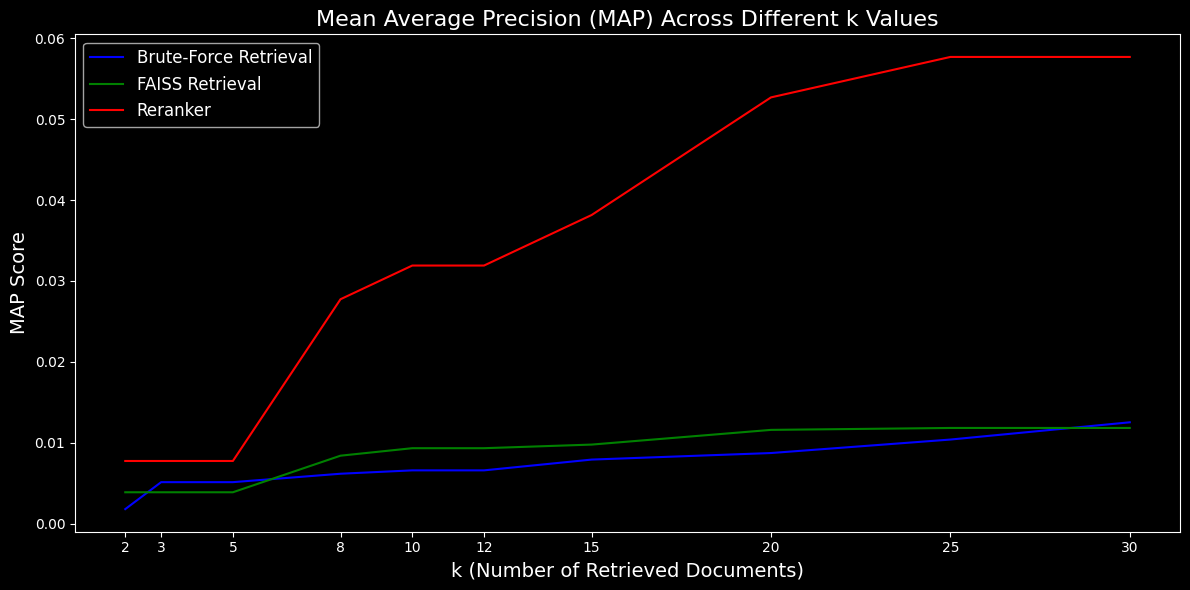

In [35]:
plt.figure(figsize=(12, 6))

plt.plot(k_values, map_before_faiss_scores, color='blue',  label='Brute-Force Retrieval')
plt.plot(k_values, map_after_faiss_scores,  color='green', label='FAISS Retrieval')
plt.plot(k_values, map_reranker_scores,     color='red',   label='Reranker')

plt.title('Mean Average Precision (MAP) Across Different k Values', fontsize=16)
plt.xlabel('k (Number of Retrieved Documents)', fontsize=14)
plt.ylabel('MAP Score', fontsize=14)
plt.xticks(k_values)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()